<a href="https://colab.research.google.com/github/nityasinghal-14/Object-Detection-Using-CNN/blob/main/Object_Detection_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 14.9 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
from PIL import Image

In [9]:
# Load the MobileNet model for feature extraction and object detection
mobilenet_model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

In [10]:
# Load the YOLO model for bounding box refinement
yolo_model = YOLO("yolov5su.pt")  # Choose a small YOLO model for quick detection

In [19]:
def preprocess_image(image):
    """Preprocesses the image for the MobileNet model."""
    # Convert the image to RGB if it's in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image if necessary, but keep it flexible
    image = tf.image.resize_with_pad(image, 300, 300) # maintain aspect ratio
    # Convert the image to a tensor and normalize pixel values to the range [0, 255]
    # Cast the image to uint8 before converting to tensor
    image = tf.cast(image, dtype=tf.uint8)
    # Add a batch dimension (MobileNet expects a batch of images)
    image = tf.expand_dims(image, axis=0)
    return image

In [20]:
def detect_objects_mobilenet(image):
    # Preprocess the image and pass it through MobileNet
    processed_image = preprocess_image(image)
    result = mobilenet_model(processed_image)

    # Extract bounding boxes and classes from the result
    boxes = result['detection_boxes'].numpy()
    classes = result['detection_classes'].numpy()
    scores = result['detection_scores'].numpy()

    return boxes, classes, scores

In [21]:
def refine_boxes_with_yolo(image, boxes, classes, scores, score_threshold=0.5):
    refined_boxes = []

    for box, cls, score in zip(boxes, classes, scores):
        if np.any(score >= score_threshold):  # Apply score threshold from MobileNet using np.any()
            ymin, xmin, ymax, xmax = box[0]
            height, width, _ = image.shape
            roi = image[int(ymin * height):int(ymax * height), int(xmin * width):int(xmax * width)]

            # Use YOLO to detect objects within the ROI
            yolo_results = yolo_model(roi)

            # Check if YOLO results is not empty
            if yolo_results and yolo_results[0] is not None and len(yolo_results[0].boxes):
                # Extract bounding boxes and add them to refined_boxes
                # (Adjusting coordinates to the original image)
                for *xyxy, conf, cls_yolo in yolo_results[0].boxes.data:  # Access boxes data and unpack
                    x1, y1, x2, y2 = map(int, xyxy)  # Convert to integers
                    refined_boxes.append((
                        int(xmin * width + x1),
                        int(ymin * height + y1),
                        int(xmin * width + x2),
                        int(ymin * height + y2),
                        conf.item(),  # Include confidence score
                        cls_yolo.item()  # Include class from YOLO
                    ))
            else:
                print("No YOLO results for this box")

    return refined_boxes

In [22]:
def hybrid_object_detection(image):
    # Detect objects using MobileNet
    boxes, classes, scores = detect_objects_mobilenet(image)

    # Refine the boxes using YOLO
    refined_boxes = refine_boxes_with_yolo(image, boxes, classes, scores)

    # Draw rectangles for each refined box
    for x1, y1, x2, y2, confidence, cls_yolo in refined_boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add label with confidence and class
        label = f"{cls_yolo}: {confidence:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

In [23]:
# Load an example image
image_path = "/content/aeroplane.jpg"
image = cv2.imread(image_path)


0: 160x640 1 airplane, 182.5ms
Speed: 2.8ms preprocess, 182.5ms inference, 1.6ms postprocess per image at shape (1, 3, 160, 640)


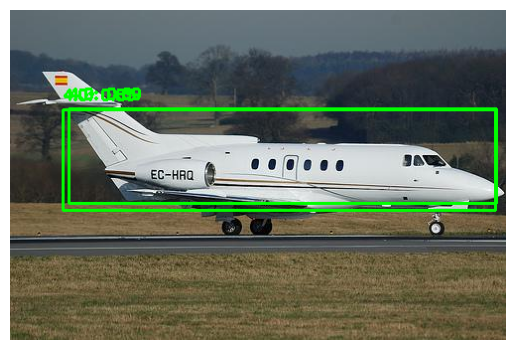

In [26]:
# Run hybrid object detection
result_image = hybrid_object_detection(image)

# Display the result using matplotlib
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


0: 384x640 1 bicycle, 631.6ms
Speed: 3.5ms preprocess, 631.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


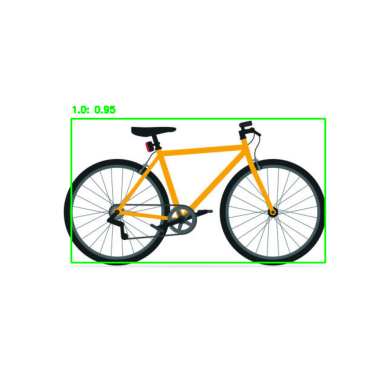

In [17]:
image_path = "/content/cycle.jpg"
image = cv2.imread(image_path)

# Run hybrid object detection
result_image = hybrid_object_detection(image)

# Display the result using matplotlib
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


0: 640x256 1 person, 1 bicycle, 258.4ms
Speed: 4.2ms preprocess, 258.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 256)


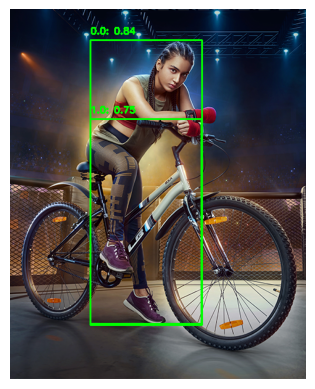

In [18]:
image_path = "/content/bicycle.png"
image = cv2.imread(image_path)

# Run hybrid object detection
result_image = hybrid_object_detection(image)

# Display the result using matplotlib
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()